In [5]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
import pickle
import numpy as np
from sklearn.metrics import roc_auc_score, average_precision_score
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
from glob import glob
import torch

plt.rcParams['svg.fonttype'] = 'none'

os.chdir("/project/lcd_v2")
from run.tools.cli.infer import prepare_inference



dataset_id = [1, 2, 3] # 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 21, 22, 23, 24]
methods = ['correlation', 'dynotears', 'granger_causality', 'mutual_info', 'pcmciplus', 'var_lingam']  # 'cmlp', 'clstm', 'esru', 'sru']


In [6]:
# helper function
def float2binary(l):
    l = np.where(l!=0, 1, 0)
    return l

def seed_everything(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(42)

def add_normalized_noise(X, scale=0.1, _seed=42):
    np.random.seed(_seed)
    return X + scale * np.random.normal(0, 1.0, X.shape) * (
                    X.max() - X.min()
                )

In [7]:
note = "default"
note_postfix = "" if note == "default" else f"_note={note}"
res = {i: {method: pickle.load(open(f"/project/lcd_v2/.cache/sim_data/normalized/netsim_auc_result/dataset=netsim_{i}-method={method}{note_postfix}.pkl", "rb")) for method in methods} for i in dataset_id}

In [8]:
# load other baselines result
score = {}

for idx in dataset_id:
    score[idx] = {}
    score_auroc, score_auprc = [], []
    for method in methods:
        score[idx][method] = {}
        preds, labels = [], []
        for subject in res[idx][method]:
            label = float2binary(subject['label']).reshape(-1)
            pred = np.abs(subject['pred'].reshape(-1))
            pred = np.where(pred==np.inf, 100, pred)
            preds.append(pred)
            labels.append(label)
            score_auroc.append(roc_auc_score(label, pred))
            score_auprc.append(average_precision_score(label, pred))

        score[idx][method] = {'auroc': np.mean(score_auroc),
                              'auroc_std': np.std(score_auroc),
                              'auprc': np.mean(score_auprc),
                              'auprc_std': np.std(score_auprc)}
       # print mean and std of each method
        print("--------------------------")
        print(f"dataset {idx}, method {method}, auroc: {score[idx][method]['auroc']}, auprc: {score[idx][method]['auprc']}")


--------------------------
dataset 1, method correlation, auroc: 0.8344999999999999, auprc: 0.46972619047619046
--------------------------
dataset 1, method dynotears, auroc: 0.6672499999999999, auprc: 0.33486309523809527
--------------------------
dataset 1, method granger_causality, auroc: 0.657666666666667, auprc: 0.34423256373256367
--------------------------
dataset 1, method mutual_info, auroc: 0.6679999999999999, auprc: 0.3515950577200577
--------------------------
dataset 1, method pcmciplus, auroc: 0.6528999999999999, auprc: 0.3462093795093794
--------------------------
dataset 1, method var_lingam, auroc: 0.67825, auprc: 0.3921165715233053
--------------------------
dataset 2, method correlation, auroc: 0.8864147088866192, auprc: 0.44499907511102277
--------------------------
dataset 2, method dynotears, auroc: 0.6932073544433095, auprc: 0.2774995375555115
--------------------------
dataset 2, method granger_causality, auroc: 0.6813755532856658, auprc: 0.27848930255154003
---

In [9]:
# # load sru and eSRU result
# sru_dir = ".cache/netsim/logs"
#
# for idx in dataset_id:
#     for method in ["eSRU_2LF", "sru"]:
#         files = glob(f"{sru_dir}/regular_model_{method}_ds_netsim_dsid_{idx}_subj_*.npz")
#         preds, labels = [], []
#         for file in files:
#             data = np.load(file)
#             label = data['Gref']
#             pred = data['Gest']
#             preds.append(pred.reshape(-1))
#             labels.append(label.reshape(-1))
#         preds = np.concatenate(preds, axis=0)
#         labels = np.where(np.concatenate(labels, axis=0)!=0, 1, 0)
#         score[idx][method] = {'auroc': roc_auc_score(labels, preds),
#                               'auprc': average_precision_score(labels, preds)}


In [69]:
import scipy.io as sio
import torch

# load proposed method result
percentage_start, percentage_end = 0.8, 1.0
ckpt_path = 'work_dir/netsim_transformer_128/ckpts/exp_name=netsim_transformer_128-cfg=netsim_transformer_128-bs=256-seed=42-val_average_precision=0.7720.ckpt'
cfg_path = 'work_dir/netsim_transformer_128/netsim_transformer_128.py'

di, mi = prepare_inference(cfg_path, ckpt_path)

mi = mi.cuda()

for idx in tqdm(dataset_id):
    if note == "noise":
        sim_file = f".cache/netsim/sim{idx}_noisy.mat"
    else:
        sim_file = f".cache/netsim/sim{idx}.mat"
    preds = []
    labels = []

    # make the pairwise samples and prediction
    mat = sio.loadmat(sim_file)

    n_subjects, n_node, duration = (
        int(mat["Nsubjects"]),
        int(mat["Nnodes"]),
        int(mat["Ntimepoints"]),
    )
    if note == "noise":
        slice = [0, int(n_subjects*(percentage_end-percentage_start))]
    else:
        slice = [
            int(percentage_start * n_subjects),
            int(percentage_end * n_subjects),
        ]
    ts = [mat["ts"][i:i+duration] for i in range(duration * slice[0], duration * slice[1], duration)]
    gref = [mat["net"][i] for i in range(slice[0], slice[1])]

    T, N = ts[0].shape
    score_auroc, score_auprc = [], []
    for _ts, _gref in zip(ts, gref):
        examples = np.concatenate([np.stack([np.stack((_ts[:, i], _ts[:, j]), axis=-1)for j in range(N)], axis=0) for i in range(N)], axis=0)
        examples = torch.tensor(examples, dtype=torch.float32).cuda()
        pred = mi(examples)
        pred = pred.softmax(dim=-1)[:, 1].detach().cpu().numpy()
        # parse the prediction to the original shape
        _gest = np.zeros((N, N))
        for i in range(N):
           for j in range(N):
             _gest[i, j] = pred[i*N+j]

        mask = np.eye(N, dtype=bool)
        _gest = _gest[~mask].reshape(-1)
        _gref = np.where(_gref!=0, 1, 0)[~mask].reshape(-1)

        score_auroc.append(roc_auc_score(_gref, _gest))
        score_auprc.append(average_precision_score(_gref, _gest))

    mean_auroc = np.mean(score_auroc)
    mean_auprc = np.mean(score_auprc)

    if idx not in score:
        score[idx] = {}
    score[idx]['transformer'] = {'auroc': mean_auroc,
                                 'auroc_std': np.std(score_auroc),
                                 'auprc': mean_auprc,
                                 'auprc_std': np.std(score_auprc)}
    # print mean and std of each dataset
    print("--------------------------")
    print(f"dataset {idx}, method transformer, auroc: {score[idx]['transformer']['auroc']}, auprc: {score[idx]['transformer']['auprc']}")



Lightning automatically upgraded your loaded checkpoint from v1.6.4 to v1.9.1. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file work_dir/netsim_transformer_128/ckpts/exp_name=netsim_transformer_128-cfg=netsim_transformer_128-bs=256-seed=42-val_average_precision=0.7720.ckpt`
/usr/local/lib/python3.9/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AveragePrecision` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.9/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


  0%|          | 0/17 [00:00<?, ?it/s]

--------------------------
dataset 1, method transformer, auroc: 0.8651851851851853, auprc: 0.777153926320593
--------------------------
dataset 2, method transformer, auroc: 0.9023142820611175, auprc: 0.6760873273015578
--------------------------
dataset 3, method transformer, auroc: 0.8897569444444444, auprc: 0.5011090845651096
--------------------------
dataset 8, method transformer, auroc: 0.8222222222222223, auprc: 0.6808601420366126
--------------------------
dataset 10, method transformer, auroc: 0.8385185185185186, auprc: 0.7309876851543518
--------------------------
dataset 11, method transformer, auroc: 0.8170310701956272, auprc: 0.41534219863007826
--------------------------
dataset 12, method transformer, auroc: 0.8819844009717427, auprc: 0.5961682819230392
--------------------------
dataset 13, method transformer, auroc: 0.5800010175010175, auprc: 0.5552391705414428
--------------------------
dataset 14, method transformer, auroc: 0.9022222222222224, auprc: 0.8245726640824

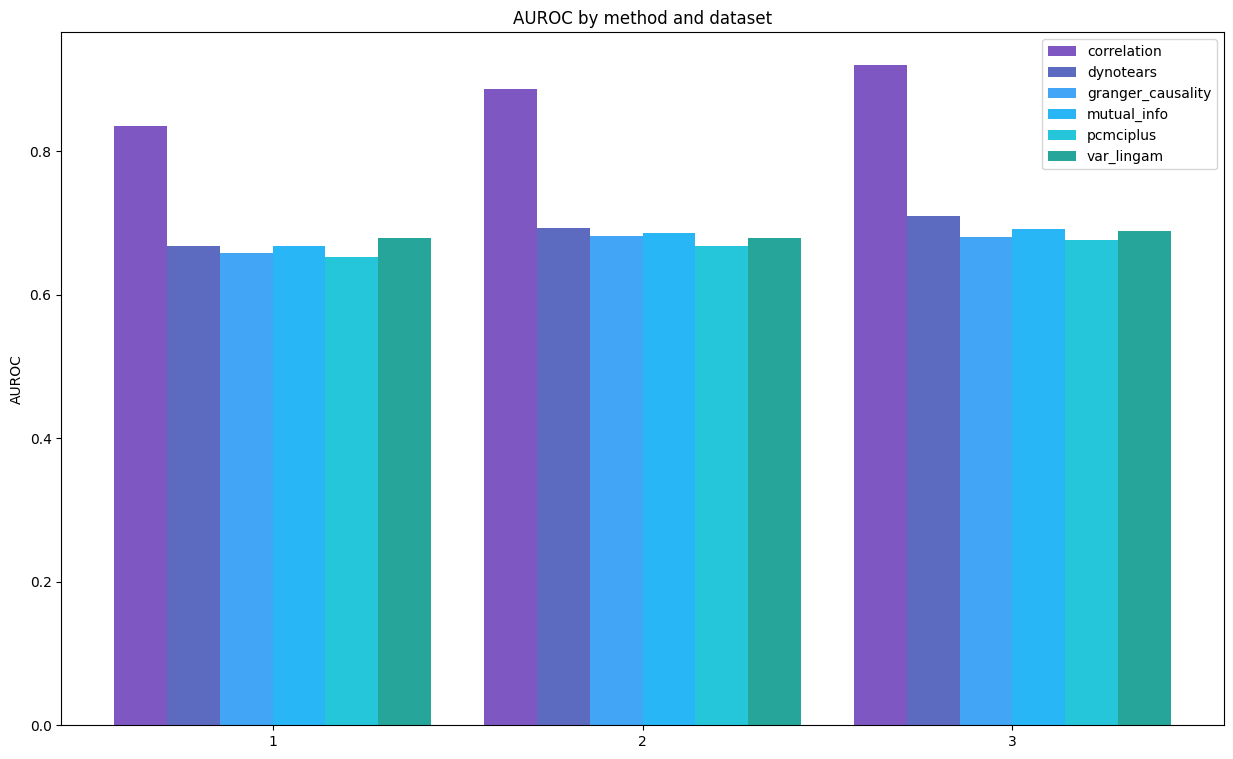

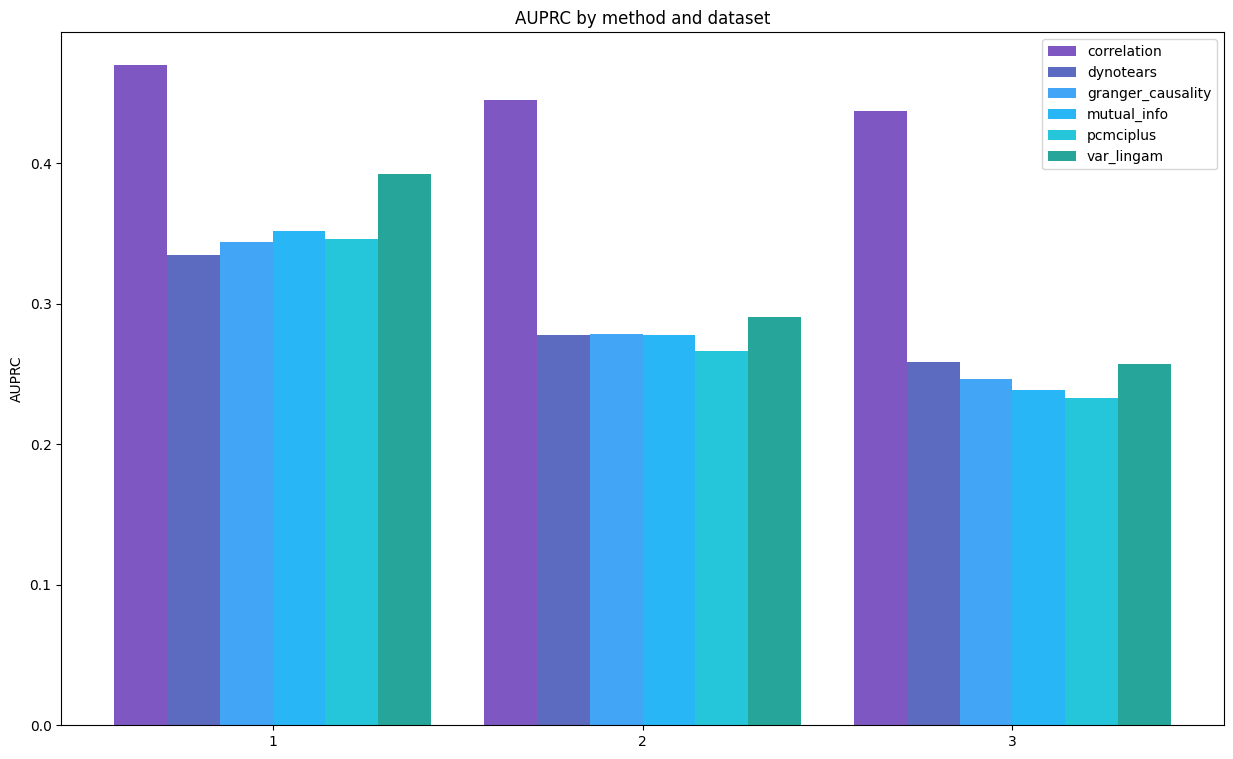

In [10]:
def plot_performance(score, metric="auroc"):
    dataset_names = list(score.keys())
    n_datasets = len(dataset_names)

    # Prepare data for plotting
    method_names = list(next(iter(score.values())).keys())
    n_methods = len(method_names)
    data = {method: [] for method in method_names}
    mean_std_data = {method: {"mean": [], "std": []} for method in method_names}

    for dataset, methods in score.items():
        for method, performance in methods.items():
            data[method].append(performance[metric])
            mean_std_data[method]["mean"].append(np.mean(performance[metric]))
            mean_std_data[method]["std"].append(np.std(performance[metric]))

    # Plot the bar chart
    fig, ax = plt.subplots(figsize=(15, 9))
    width = 1 / (n_methods + 1)
    x = np.arange(n_datasets)

    # Use "tab10" colormap for visually pleasing colors
    # colors = plt.cm.tab10(np.linspace(0, 1, n_methods))
    colors =  [
        "#7E57C2", # Purple
        "#5C6BC0", # Indigo
        "#42A5F5", # Blue
        "#29B6F6", # Light Blue
        "#26C6DA", # Cyan
        "#26A69A", # Teal
        "#66BB6A", # Green
        "#9CCC65", # Light Green
        "#D4E157", # Lime
        "#FFEE58", # Yellow
        "#FFCA28", # Amber
    ]

    for idx, (method, performance) in enumerate(data.items()):
        color = colors[idx % len(colors)]
        bar = ax.bar(x + width * idx, mean_std_data[method]["mean"], width, label=method, capsize=4, color=color)
        # bar = ax.bar(x + width * idx, mean_std_data[method]["mean"], width, yerr=mean_std_data[method]["std"], label=method, capsize=4)
        # for i, v in enumerate(mean_std_data[method]["mean"]):
        #     ax.text(
        #         x[i] + width * idx - 0.1,
        #         v + 0.01,
        #         f"{v:.2f}±{mean_std_data[method]['std'][i]:.2f}",
        #         fontsize=8,
        #     )

    # Customize the plot
    ax.set_ylabel(metric.upper())
    ax.set_title(f"{metric.upper()} by method and dataset")
    ax.set_xticks(x + width * (n_methods - 1) / 2)
    ax.set_xticklabels(dataset_names)
    ax.legend()

    # Show the plot
    plt.show()

# Call the function with your score dictionary
plot_performance(score, metric="auroc")
plot_performance(score, metric="auprc")

In [71]:
score

{1: {'correlation': {'auroc': 0.7675,
   'auroc_std': 0.06527825058930425,
   'auprc': 0.4166428571428572,
   'auprc_std': 0.052694887169315086},
  'dynotears': {'auroc': 0.7300000000000001,
   'auroc_std': 0.07186793443532379,
   'auprc': 0.3563994636254698,
   'auprc_std': 0.07501105135275898},
  'granger_causality': {'auroc': 0.704,
   'auroc_std': 0.10308087439805053,
   'auprc': 0.3835823818997194,
   'auprc_std': 0.1312530099049882},
  'mutual_info': {'auroc': 0.70225,
   'auroc_std': 0.09543289527201823,
   'auprc': 0.3794357943612975,
   'auprc_std': 0.11843301299358036},
  'pcmciplus': {'auroc': 0.6698,
   'auroc_std': 0.11080595651859154,
   'auprc': 0.3595486354890379,
   'auprc_std': 0.1186722343492024},
  'var_lingam': {'auroc': 0.6815,
   'auroc_std': 0.12038583803753662,
   'auprc': 0.38866450273725817,
   'auprc_std': 0.15066063588507486},
  'cmlp': {'auroc': 0.6779285714285715,
   'auroc_std': 0.11901828448106756,
   'auprc': 0.38453615689927056,
   'auprc_std': 0.1480

In [76]:
txt = []

metric = 'auroc'
methods_name = ['correlation', 'dynotears', 'granger_causality', 'mutual_info', 'pcmciplus', 'var_lingam',  'cmlp', 'clstm', 'esru', 'sru', 'transformer']
for id in dataset_id:
    methods = [f"${score[id][method][f'{metric}']:.2f} \pm {score[id][method][f'{metric}_std']:.2f}$" for method in methods_name]
    best_method = np.argmax([score[id][method][f'{metric}'] for method in methods_name])
    methods[best_method] = f"\\textbf{{{score[id][methods_name[best_method]][f'{metric}']:.2f}}}$\pm$\\textbf{{{score[id][methods_name[best_method]][f'{metric}_std']:.2f}}}"
    txt.append(f"{id}  & {methods[0]} & {methods[1]} & {methods[2]} & {methods[3]} & {methods[4]} & {methods[5]} & {methods[6]} & {methods[7]} & {methods[8]} & {methods[9]} & {methods[10]} \\\\")
open("score_transformer.txt", "w").write("\n".join(txt))

3803

### Prediction example for NetSim

In [10]:
axes

array([[<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >]], dtype=object)

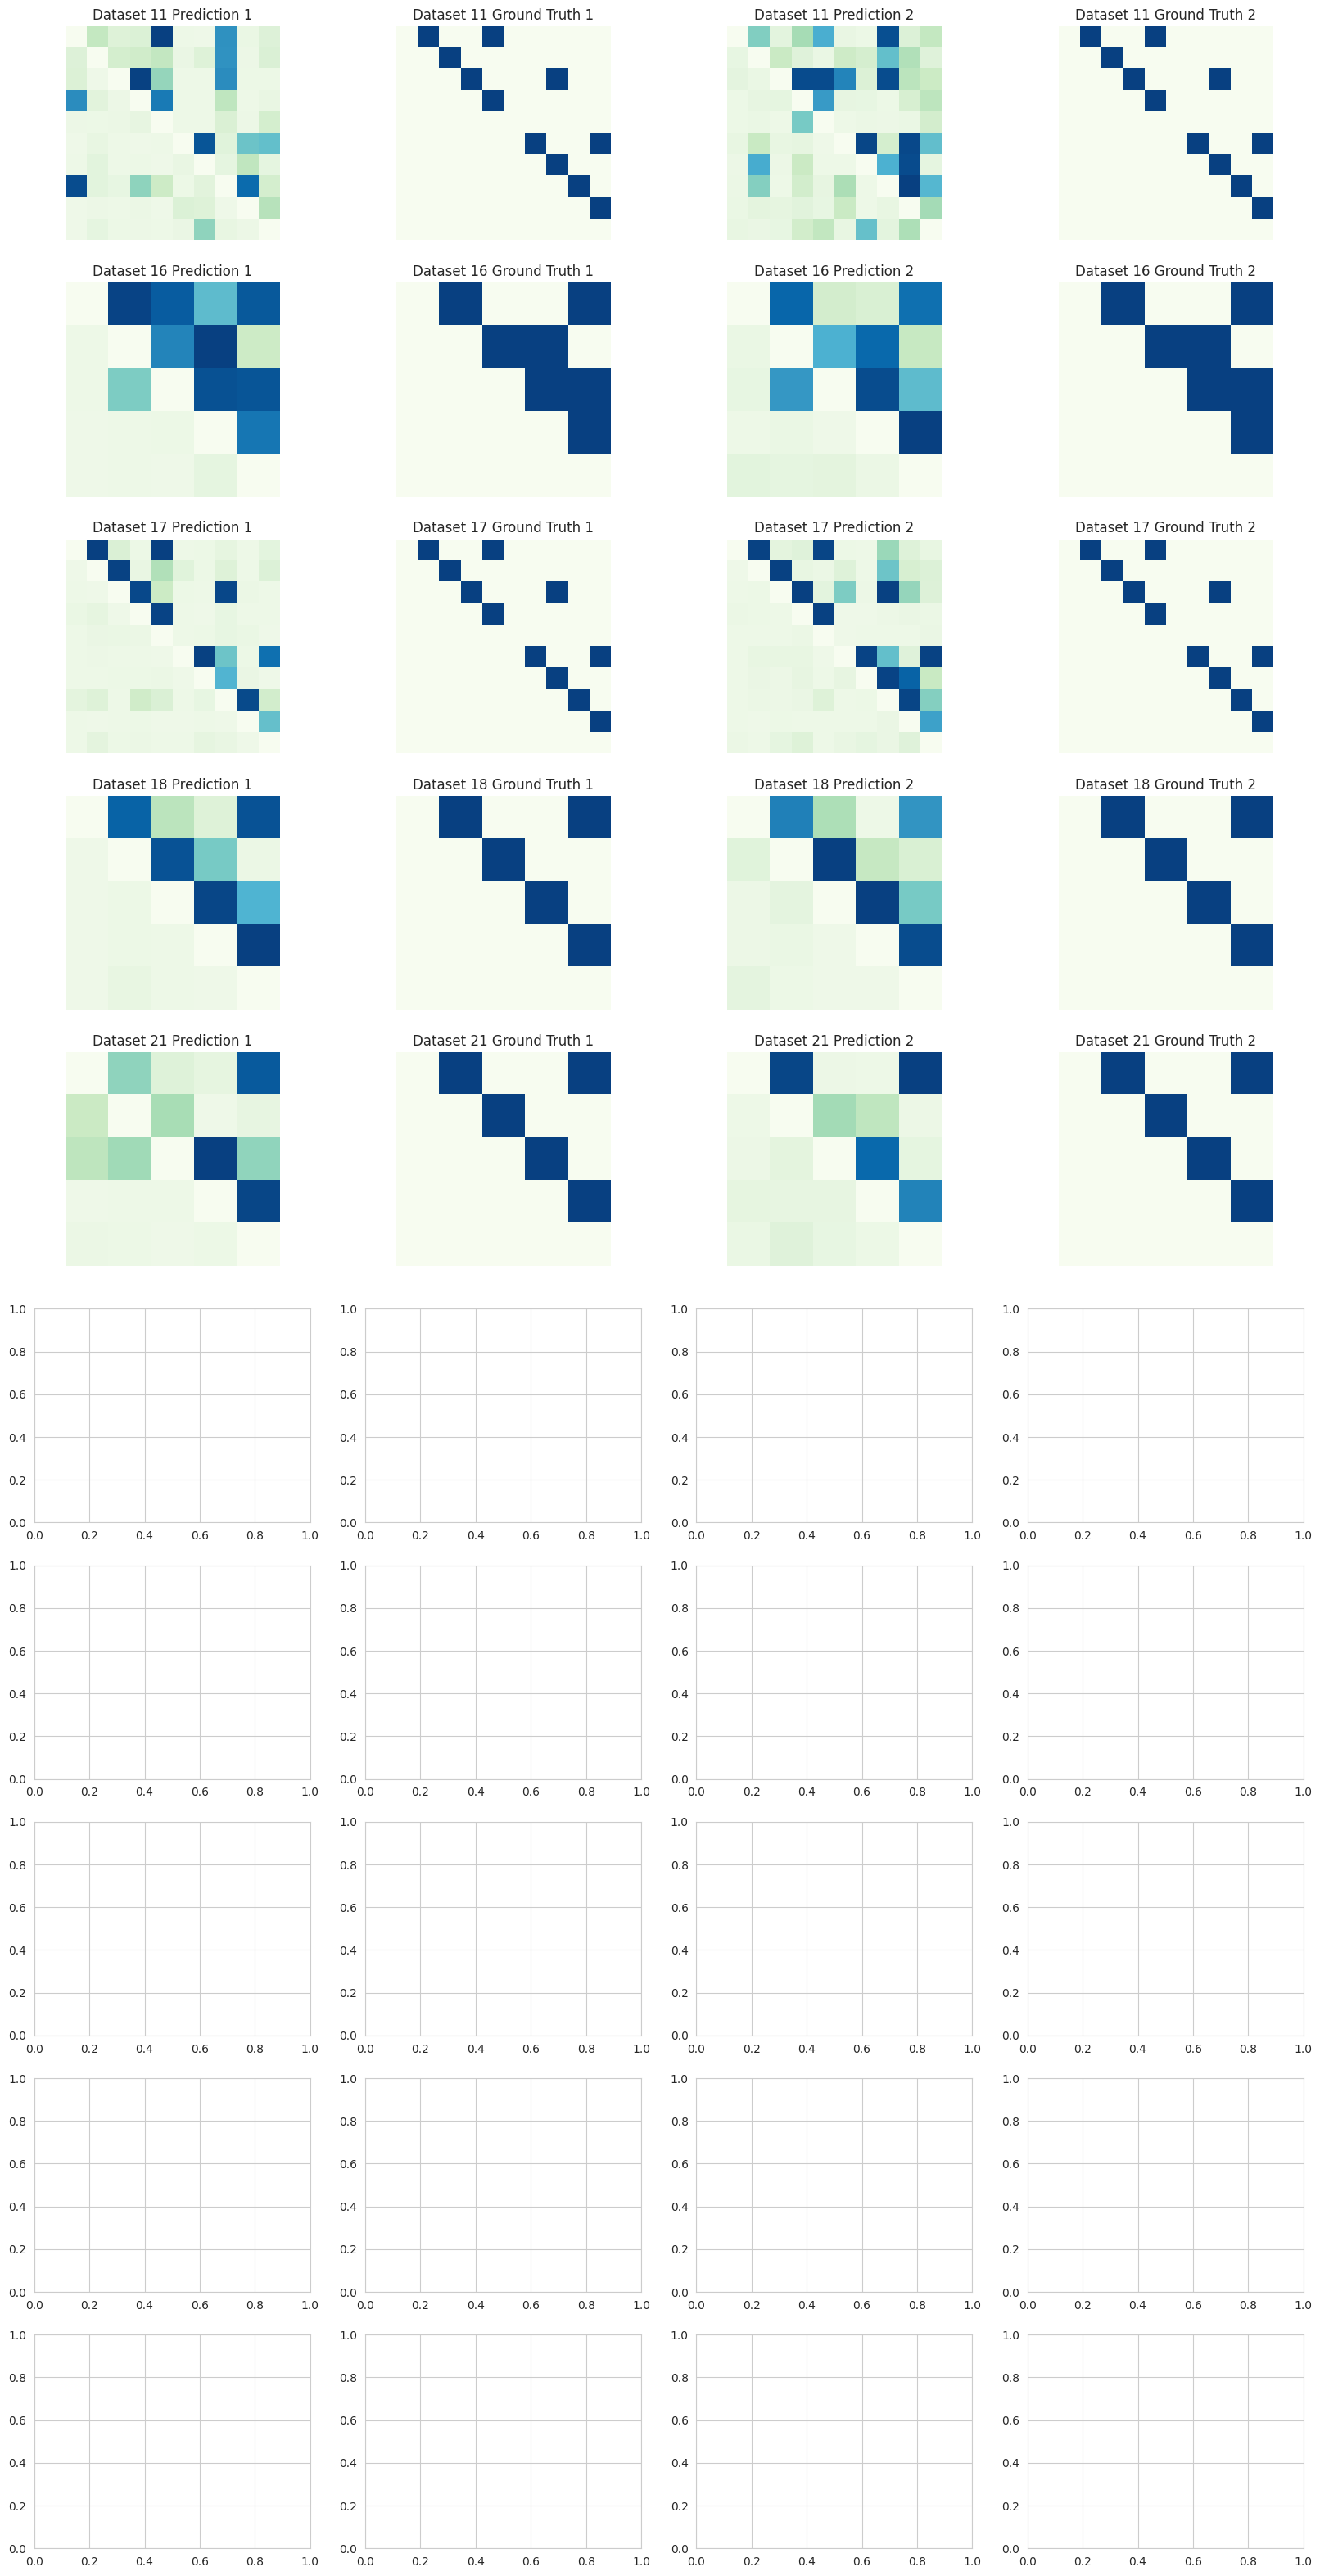

In [34]:
import scipy.io as sio
import torch

# load proposed method result
percentage_start, percentage_end = 0.8, 1.0
ckpt_path = 'work_dir/netsim_transformer_128/ckpts/exp_name=netsim_transformer_128-cfg=netsim_transformer_128-bs=256-seed=42-val_average_precision=0.7720.ckpt'
cfg_path = 'work_dir/netsim_transformer_128/netsim_transformer_128.py'

di, mi = prepare_inference(cfg_path, ckpt_path)

mi = mi.cuda()

dataset_id = [11, 16, 17, 18, 21]

fig, axes = plt.subplots(5, 6, figsize=(30, 25))

for ii, idx in enumerate(dataset_id):
    sim_file = f".cache/netsim/sim{idx}.mat"
    preds = []
    labels = []

    # make the pairwise samples and prediction
    mat = sio.loadmat(sim_file)

    n_subjects, n_node, duration = (
        int(mat["Nsubjects"]),
        int(mat["Nnodes"]),
        int(mat["Ntimepoints"]),
    )
    slice = [
        int(percentage_start * n_subjects),
        int(percentage_end * n_subjects),
    ]
    ts = [mat["ts"][i:i+duration] for i in range(duration * slice[0], duration * slice[1], duration)]
    gref = [mat["net"][i] for i in range(slice[0], slice[1])]

    T, N = ts[0].shape
    score_auroc, score_auprc = [], []
    for jdx, (_ts, _gref) in enumerate(zip(ts, gref)):
        if jdx == 3:
            break
        examples = np.concatenate([np.stack([np.stack((_ts[:, i], _ts[:, j]), axis=-1)for j in range(N)], axis=0) for i in range(N)], axis=0)
        examples = torch.tensor(examples, dtype=torch.float32).cuda()
        pred = mi(examples)
        pred = pred.softmax(dim=-1)[:, 1].detach().cpu().numpy()
        # parse the prediction to the original shape
        _gest = np.zeros((N, N))
        for i in range(N):
           for j in range(N):
             _gest[i, j] = pred[i*N+j]

        _gref = np.where(_gref != 0, 1, 0)

        for i in range(N):
            for j in range(N):
                if i == j:
                    _gest[i, j] = 0
                    _gref[i, j] = 0

        # plot the prediction
        axes[ii][jdx*2].imshow(_gest, cmap="GnBu")
        axes[ii][jdx*2].set_title(f"Dataset {idx} Prediction {jdx+1}")
        axes[ii][jdx*2].axis("off")

        # plot the ground truth
        axes[ii][jdx*2+1].imshow(_gref, cmap="GnBu")
        axes[ii][jdx*2+1].set_title(f"Dataset {idx} Ground Truth {jdx+1}")
        axes[ii][jdx*2+1].axis("off")

fig.savefig("figure/Figure 6. Supplemental/netsim_demo_1116171821.pdf")

